# Kidney Stone Risk Prediction — Baseline Modeling

This notebook builds baseline machine learning models to predict kidney stone risk.  
The goal is to establish a clean, reproducible modeling pipeline using standard preprocessing, cross-validation, and evaluation metrics (ROC-AUC and PR-AUC).

The advanced modeling, calibration, threshold selection, and interpretability steps are handled in `03_advanced_modeling.ipynb`.


In [1]:
import sys
sys.path.append("..")

import pandas as pd
import os
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

from src.preprocessing import split_features_target, get_feature_types, build_preprocessor
from src.modeling import build_logistic_regression, build_random_forest
from src.evaluation import evaluate_model, plot_roc_pr
from sklearn.base import clone
from sklearn.model_selection import cross_validate, StratifiedKFold

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)


In [2]:
# Load dataset
DATA_PATH = Path("../data/raw/cleaned_stone.csv")
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)


Shape: (4000, 24)


In [3]:
# Anti-leakage and feature/target split
leakage_cols = [c for c in ['ckd_pred','ckd_stage','cluster','months'] if c in df.columns]
X, y = split_features_target(df, target="stone_risk", leakage_cols=leakage_cols)
num_cols, cat_cols = get_feature_types(X)
print("Numèriques:", len(num_cols), "| Categòriques:", len(cat_cols), "| Excloses (leakage):", leakage_cols)


Numèriques: 11 | Categòriques: 8 | Excloses (leakage): ['ckd_pred', 'ckd_stage', 'cluster', 'months']


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


In [5]:
# Preprocessing pipeline
preprocessor = build_preprocessor(num_cols, cat_cols, strategy="median")


In [6]:
# Baseline models
# Logistic regression
log_reg = build_logistic_regression(preprocessor)

# Random forest
rf = build_random_forest(preprocessor, n_estimators=300, random_state=42)


In [7]:
# Fit models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
# Evaluation on test set
res_lr = evaluate_model(log_reg, X_test, y_test)
res_rf = evaluate_model(rf, X_test, y_test)

print(f"LogReg — Test ROC-AUC = {res_lr['roc_auc']:.3f} | PR-AUC = {res_lr['pr_auc']:.3f}")
print(f"RF      — Test ROC-AUC = {res_rf['roc_auc']:.3f} | PR-AUC = {res_rf['pr_auc']:.3f}")


LogReg — Test ROC-AUC = 0.992 | PR-AUC = 0.984
RF      — Test ROC-AUC = 0.999 | PR-AUC = 0.998


In [9]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc": "roc_auc",
    "pr": "average_precision"
}

for name, model in [("LogReg", log_reg), ("RF", rf)]:
    res = cross_validate(
        model,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        error_score="raise"
    )

    roc_scores = res["test_roc"]
    pr_scores = res["test_pr"]

    print(f"{name} – CV ROC-AUC: {roc_scores.mean():.3f} ± {roc_scores.std():.3f} | "
          f"CV PR-AUC: {pr_scores.mean():.3f} ± {pr_scores.std():.3f}")


LogReg – CV ROC-AUC: 0.991 ± 0.003 | CV PR-AUC: 0.982 ± 0.007
RF – CV ROC-AUC: 0.998 ± 0.001 | CV PR-AUC: 0.997 ± 0.001


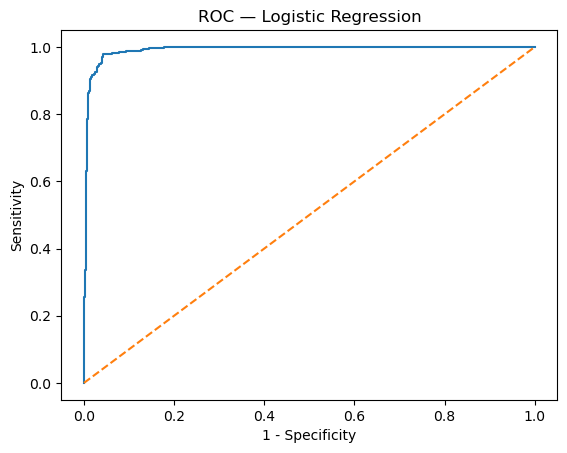

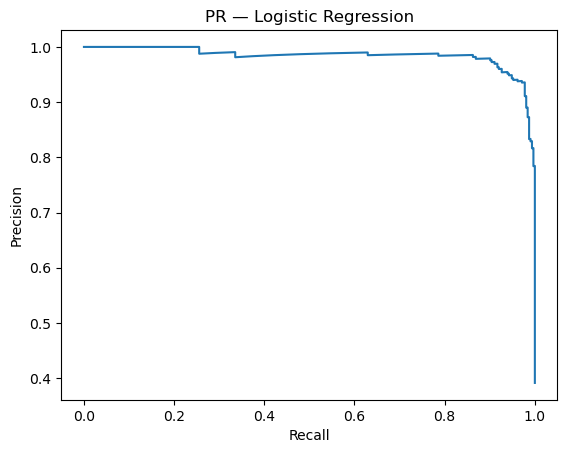

<Figure size 640x480 with 0 Axes>

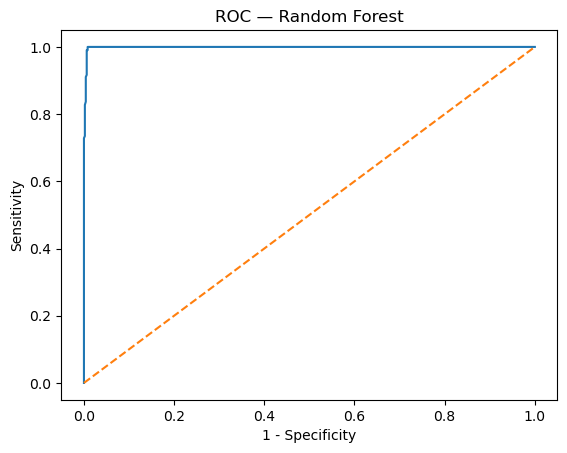

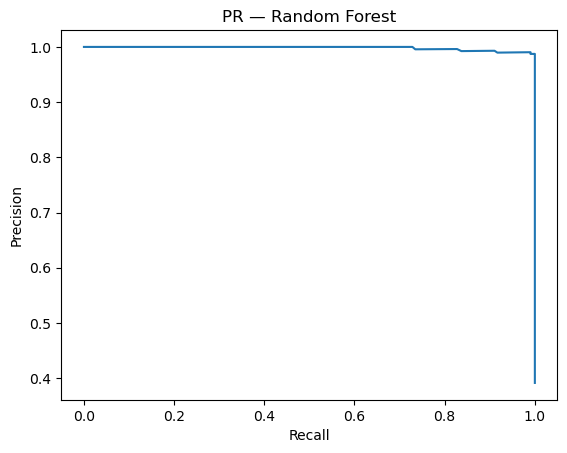

<Figure size 640x480 with 0 Axes>

In [10]:
# ROC and PR curves
os.makedirs("../reports/figures", exist_ok=True)

# Logistic Regression
p_lr = log_reg.predict_proba(X_test)[:, 1]
plot_roc_pr(p_lr, y_test, "Logistic Regression")

plt.savefig("../reports/figures/roc_lr.png", dpi=300, bbox_inches="tight")
plt.show()

plt.savefig("../reports/figures/pr_lr.png", dpi=300, bbox_inches="tight")
plt.show()

# Random Forest
p_rf = rf.predict_proba(X_test)[:, 1]
plot_roc_pr(p_rf, y_test, "Random Forest")

plt.savefig("../reports/figures/roc_rf.png", dpi=300, bbox_inches="tight")
plt.show()

plt.savefig("../reports/figures/pr_rf.png", dpi=300, bbox_inches="tight")
plt.show()


# Baseline modeling conclusions

- Both Logistic Regression and Random Forest achieve reasonable discrimination performance.
- Cross-validation results are consistent with test-set performance, suggesting stable generalization.
- Random Forest typically performs slightly better in non-linear relationships, but both models will be compared again after calibration and interpretability analysis.

Advanced modeling, calibration, threshold selection, and interpretability are performed in `03_advanced_modeling.ipynb`.
